#### Predict tags on StackOverflow with linear models

In this assignment we will learn how to predict multi tags for individul posts from [StackOverflow](https://stackoverflow.com). To solve this task we will use multilabel classification approach.

### Data

The following cell will download all data required for this assignment.

In [1]:
import sys
sys.path.append("common")
from download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


### Text preprocessing

We will need to use a list of stop words downloaded from *nltk*:

In this task we will deal with a dataset of post titles from StackOverflow. We are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [2]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [3]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [4]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [5]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [6]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent these problems, it's usually useful to prepare the data somehow. So we'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_test_prepare* to test it on tiny cases.

In [7]:
import re
import pickle

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = list(pickle.load(open( "stopwords.p", "rb" ) ))



def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('',text) # delete symbols which are in BAD_SYMBOLS_RE from text
    txt_split = text.split()
    for word in text.split():
        if word in STOPWORDS: 
            txt_split.remove(word) # delete stopwords from text   
    text = ' '.join(txt_split) 
    return text

In [9]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [10]:
print(test_text_prepare())

Basic tests are passed.


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [11]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [12]:
X_train[:6]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl',
 'awesome nested set plugin add new children tree various levels']

For each tag and for each word calculate how many times they occur in the train corpus. 
Here are 3 most popular tags and 3 most popular words in the train data:

In [13]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
for i in range(len(y_train)):
    for y in y_train[i]:
        tags_counts[y] = 0

for i in range(len(y_train)):
    for y in y_train[i]:
         tags_counts[y] += 1
tags_counts_sorted = sorted(tags_counts,key = lambda k:tags_counts[k],reverse=True)
print(tags_counts_sorted[0:3])
  
# Dictionary of all words from train corpus with their counts.
words_counts = {}
for word in X_train:
    for x in word.split():
         words_counts[x] = 0

for word in X_train:
    for x in word.split():
        words_counts[x] += 1
words_counts_sorted = sorted(words_counts,key = lambda k:words_counts[k],reverse=True)
print(words_counts_sorted[0:3])


['javascript', 'c#', 'java']
['using', 'php', 'java']


In [14]:
len(words_counts), len(tags_counts)

(31497, 100)

After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`.

### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. We will try to use two of them.

#### Bag of words

One of the well-known approaches is the *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Here is how it works for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. We can test the code using the function *test_my_bag_of_words*.

In [50]:
DICT_SIZE = 5000

most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

WORDS_TO_INDEX = {most_common_words[i][0]:i for i in range(len(most_common_words))} 


INDEX_TO_WORDS = {i:most_common_words[i][0] for i in range(len(most_common_words))}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    
    for word in text.split():
        if word in words_to_index:
            idx = words_to_index[word]
            if idx<dict_size: result_vector[idx] = 1
    
    return result_vector

In [16]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [17]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [18]:
from scipy import sparse as sp_sparse

In [19]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

### BagOfWords

For the 11th row in *X_train_mybag* find how many non-zero elements it has.

In [20]:
X_train[10]

'obtaining object javalangclasst object parameterized type without constructing class q_uestion'

In [21]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = (row !=0).sum()

non_zero_elements_count

7

#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

We implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Also, we filter out too rare words (occur less than in 5 titles), too frequent words (occur more than in 90% of the titles) and use bigrams along with unigrams in your vocabulary. 

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
      
    tfidf_vectorizer = TfidfVectorizer(min_df=0.0005, max_df=0.9, ngram_range=(1,2), token_pattern='(\S+)')
    X_train = sp_sparse.csr_matrix(tfidf_vectorizer.fit_transform(X_train))
    X_val = sp_sparse.csr_matrix(tfidf_vectorizer.transform(X_val))
    X_test = sp_sparse.csr_matrix(tfidf_vectorizer.transform(X_test))
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once we have done text preprocessing, let's have a look at the results as the performance of future models will drastically depend on this stage. 

In this case, we check whether if we have c++ or c# in our vocabulary, as they are obviously important tokens in our tags prediction task:

In [24]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [25]:
len(tfidf_vocab)

1954

In [26]:
tfidf_vocab['c#']

217

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

In [28]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [67]:
X_train[2], 

('get current time specific country via jquery',)

In [68]:
y_train[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [69]:
sorted(tags_counts.keys()).index('c#')

10

Implement the function *train_classifier* for training a classifier. In this task we use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (k = number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [29]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [30]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    
    classif = OneVsRestClassifier(LogisticRegression(random_state=0, C=1, solver='liblinear', penalty='l1'),n_jobs = -1)

    return classif.fit(X_train, y_train)
 

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [31]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now we create predictions for the data. We will need two types of predictions: labels and scores.

In [32]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [33]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	class


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




In [34]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_mybag)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	class


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [36]:
def print_evaluation_scores(y_val, predicted):
  
    print('The accuracy score is :', accuracy_score(y_val, predicted))
    print('F1-score macro/micro/weighted is :', f1_score(y_val, predicted,average='macro'),f1_score(y_val, predicted,average='micro'),f1_score(y_val, predicted,average='weighted'))
    print('F1-score macro/micro/weighted is :', average_precision_score(y_val, predicted, average='macro'),average_precision_score(y_val, predicted, average='micro'),average_precision_score(y_val, predicted, average='weighted'))

In [37]:
y_train_predicted_labels_mybag = classifier_mybag.predict(X_train_mybag)

print_evaluation_scores(y_train, y_train_predicted_labels_mybag)

The accuracy score is : 0.40763
F1-score macro/micro/weighted is : 0.5672495302968074 0.7106714339527099 0.6893317865644946
F1-score macro/micro/weighted is : 0.4071808836510003 0.5338688940926488 0.5565714179190093


In [38]:
y_train_predicted_labels_tfidf = classifier_tfidf.predict(X_train_tfidf)

print_evaluation_scores(y_train, y_train_predicted_labels_tfidf)

The accuracy score is : 0.3472
F1-score macro/micro/weighted is : 0.5063917382777864 0.6561394131227882 0.6350295601199163
F1-score macro/micro/weighted is : 0.3482601653742278 0.4686426406472381 0.49748050685102774


In [39]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
The accuracy score is : 0.3680333333333333
F1-score macro/micro/weighted is : 0.5191234634576967 0.680171935092446 0.6581540506138422
F1-score macro/micro/weighted is : 0.3580204407703642 0.4910668108337638 0.5204358394137619
Tfidf
The accuracy score is : 0.3334
F1-score macro/micro/weighted is : 0.48784890474112963 0.6448748471784314 0.6229277592507405
F1-score macro/micro/weighted is : 0.3311553350627691 0.4542573919598061 0.4851897445460647


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [40]:
from metrics import roc_auc

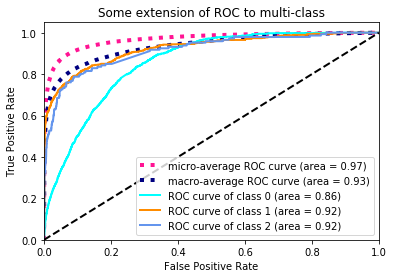

In [41]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

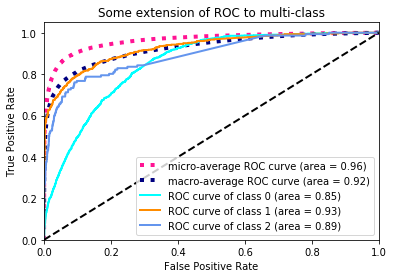

In [42]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
def train_classif_improved(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    classif = OneVsRestClassifier(LogisticRegression(random_state=0, C=1, solver='liblinear', penalty='l1'), n_jobs = -1)
    
    return classif.fit(X_train, y_train)

In [45]:
classifier_mybag_im = train_classif_improved(X_train_mybag, y_train)

#X_val_mybag = scaler.transform(X_val_mybag)

y_val_predicted_labels_mybag = classifier_mybag_im.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag_im.decision_function(X_val_mybag)

In [46]:
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)

The accuracy score is : 0.3680333333333333
F1-score macro/micro/weighted is : 0.5191234634576967 0.680171935092446 0.6581540506138422
F1-score macro/micro/weighted is : 0.3580204407703642 0.4910668108337638 0.5204358394137619


In [47]:
classifier_tfidf_im = train_classif_improved(X_train_tfidf, y_train)

#X_val_mybag = scaler.transform(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf_im.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf_im.decision_function(X_val_tfidf)

In [48]:
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

The accuracy score is : 0.3334
F1-score macro/micro/weighted is : 0.48784890474112963 0.6448748471784314 0.6229277592507405
F1-score macro/micro/weighted is : 0.3311553350627691 0.4542573919598061 0.4851897445460647


### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [99]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    tag_idx = tags_classes.index(tag)
    tag_est = classifier.estimators_[tag_idx]
    tag_coef = tag_est.coef_[0]
    
    top_positive_words = [index_to_words[i] for i in tag_coef.argsort()[-5:]] # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[i] for i in tag_coef.argsort()[:5]]# bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [100]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab)

Tag:	c
Top positive words:	linux, gcc, printf, malloc, c
Top negative words:	php, javascript, java, objective c, python

Tag:	c++
Top positive words:	stdstring, mfc, qt, boost, c++
Top negative words:	php, java, javascript, jquery, python

Tag:	linux
Top positive words:	cron, address, shared, ubuntu, linux
Top negative words:	javascript, c#, jquery, aspnet, array

